<a href="https://colab.research.google.com/github/calixphd/Quantum-Simulation-Tutorials-and-Examples/blob/main/Introduction_to_Quantum_Generative_Adversarial_Networks_Theory_with_Cirq_%26_TensorFlow_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Quantum Generative Adversarial Networks: Qiskit, Cirq & TensorFlow Implementation**

Chinonso onah & Obinna Uzoh

# Introduction

We present a model implementation Quantum Generative Adversarial Network (QGAN) using qiskit, Penylane, cirq and TensorFlow. We defer the theoretical exposition to [1], [2], and [3].

Since GAN always involves two adversaries, we realize this using two subcircuits, a generator and a discriminator. The generator attempts to generate synthetic quantum data to match a pattern of “real” data, while the discriminator tries to discern real data from fake data. The gradient of the discriminator’s output provides a training signal for the generator to improve its fake generated data.

## We begin by importing PennyLane, NumPy, and TensorFlow.

In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_finance

The first step is to install the necesary module from pennylane, tensorflow, qiskit and pennylane-cirq plugin. (use pip install pennylane, pip install pennylane-cirq, pip install tensorflow, pip install qiskit
pip install qiskit_finance). the qiskit_finance library is used to applied qGan to financial market problems.

Now, proceed to import PennyLane, NumPy, and TensorFlow.

In [ ]:
!pip install pennylane

In [ ]:
!pip install cirq

In [ ]:
import pennylane as qml
import numpy as np
import tensorflow as tf

Declare a 3-qubit simulator device on Cirq.

In [ ]:
dev = qml.device('cirq.simulator', wires=3, shots=1000)

DeviceError: ignored

# The Game of Adversaries: Generator and Discriminator

The usual starting point is to draw samples either from some “real data” distribution, or from the generator, and feed them to the discriminator. In this tutorial we will use a quantum circuit to generate the real data. See for example qiskit qGAN tutorial for an implementation on a random probability distribution [4]

For this simple tutorial, our real data will be a qubit that has been rotated from the initial state |0⟩ to some fixed state. Initialize this as follows:

In [ ]:
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

Choose the same basic circuit structure, but acting on different wires for the generator and discriminator. Both the real data circuit and the generator will output on wire 0, which will be connected as an input to the discriminator. Wire 1 is provided as a workspace for the generator, while the discriminator’s output will be on wire 2.

In [ ]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

We create two QNodes. One where the real data source is wired up to the discriminator, and one where the generator is connected to the discriminator. In order to pass TensorFlow Variables into the quantum circuits, we specify the "tf" interface.

In [ ]:
@qml.qnode(dev, interface="tf")
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, interface="tf")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

NameError: ignored

# Cost Functions, Training & Optimization

There are two cost functions of interest, corresponding to the two stages of QGAN training. These cost functions are built from two pieces: the first piece is the probability that the discriminator correctly classifies real data as real. The second piece is the probability that the discriminator classifies fake data (i.e., a state prepared by the generator) as real.

The discriminator is trained to maximize the probability of correctly classifying real data, while minimizing the probability of mistakenly classifying fake data.

CostD=Pr(real|fake)−Pr(real|real)
The generator is trained to maximize the probability that the discriminator accepts fake data as real.

CostG=−Pr(real|fake)

In [ ]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

### The Training Phase

We initialize the fixed angles of the “real data” circuit, as well as the initial parameters for both generator and discriminator. These are chosen so that the generator initially prepares a state on wire 0 that is very close to the |1⟩ state.

In [ ]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

### Create an optimizer

In [ ]:
opt = tf.keras.optimizers.SGD(0.4)

### First, optimize the discriminator while keeping the generator parameters fixed.

In [ ]:
cost = lambda: disc_cost(disc_weights)

for step in range(50):
    opt.minimize(cost, disc_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.07400000000000001
Step 5: cost = -0.27299999999999996
Step 10: cost = -0.445
Step 15: cost = -0.4780000000000001
Step 20: cost = -0.46799999999999997
Step 25: cost = -0.498
Step 30: cost = -0.512
Step 35: cost = -0.492
Step 40: cost = -0.495
Step 45: cost = -0.496


As the discriminator becomes optimal, the probability for the discriminator to correctly classify the real data should becomes close to one.

In [ ]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

Prob(real classified as real):  0.997


### Sanity check 

How does the discriminator classify the generator’s (still unoptimized) fake data:



In [ ]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.505


### Fooling the discriminator
To play the adversarial game, train the generator to better fool the discriminator. For this simple tutorial, we only perform one stage of the game. For more complex models, we would continue training the models in an alternating fashion until we reach the optimum point of the two-player adversarial game.

In [ ]:
cost = lambda: gen_cost(gen_weights)

for step in range(50):
    opt.minimize(cost, gen_weights)
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -1.0
Step 5: cost = -1.0
Step 10: cost = -1.0
Step 15: cost = -1.0
Step 20: cost = -0.999
Step 25: cost = -1.0
Step 30: cost = -1.0
Step 35: cost = -1.0
Step 40: cost = -1.0
Step 45: cost = -1.0


At the optimum of the generator, the probability for the discriminator to be fooled should be close to 1.

In [ ]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  1.0


As the two adversaries approach optimum, the discriminator cost will be close to zero, indicating that the discriminator assigns equal probability to both real and generated data indicating that the generator has successfully learned how to simulate the real data enough to fool the discriminator.

In [ ]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.0030000000000000027


# Data Comparison

Comparing the states of the real data circuit and the fake data generator, observe that the generator have learned to be in a state that is very close to the one prepared in the real data circuit. The state of the first qubit is represented through its Bloch sphere representation as follows


In [ ]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

ImportError: ignored

# Application: Option Pricing with qGANs

In this notebook, we discuss how a Quantum Machine Learning Algorithm, namely a quantum Generative Adversarial Network (qGAN), can facilitate the pricing of a European call option. More specifically, a qGAN can be trained such that a quantum circuit models the spot price of an asset underlying a European call option. The resulting model can then be integrated into a Quantum Amplitude Estimation based algorithm to evaluate the expected payoff - see European Call Option Pricing.
For further details on learning and loading random distributions by training a qGAN please refer to Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.

Import Qistkit tools

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumRegister, QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector

from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution

## The Model

The Black-Scholes model assumes that the spot price at maturity 
 for a European call option is log-normally distributed. Thus, we can train a qGAN on samples from a log-normal distribution and use the result as an uncertainty model underlying the option. Thus, we construct a quantum circuit that loads the uncertainty model. The circuit output reads

where the probabilities 
, for 
, represent a model of the target distribution.

In [ ]:
# Set upper and lower data values
bounds = np.array([0.0, 7.0])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=1.0, sigma=1.0, bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

## What is The Expected Payoff?

Now, the trained uncertainty model can be used to evaluate the expectation value of the option's payoff function with Quantum Amplitude Estimation.

set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

set the approximation scaling for the payoff function
c_approx = 0.25

### We now plot the trained probability distribution and compare with the target probability distribution.

In [ ]:
strike_price = 2
c_approx = 0.25

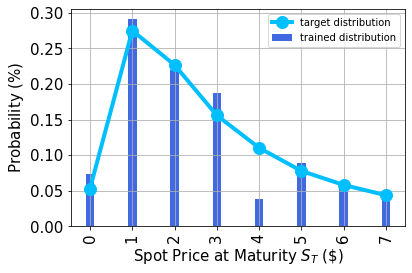

In [ ]:
# Evaluate trained probability distribution
values = [
    bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)
]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()

## Payoff for different distributions
Now the trained uncertainty model can be used to evaluate the expectation value of the option's payoff function analytically and with Quantum Amplitude Estimation.

Analytically calculated expected payoff w.r.t. the target distribution:  1.0591
Analytically calculated expected payoff w.r.t. the trained distribution: 0.9805


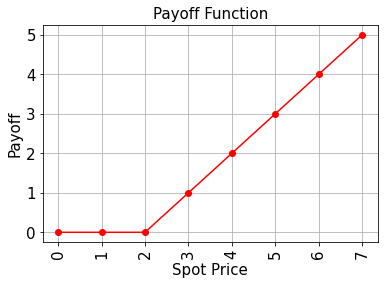

In [ ]:
payoff = np.array([0, 0, 0, 1, 2, 3, 4, 5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# Plot exact payoff function (evaluated on the grid of the trained uncertainty model)
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [ ]:
# construct circuit for payoff function
european_call_pricing = EuropeanCallPricing(
    num_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=bounds,
    uncertainty_model=uncertainty_model,
)

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

result = ae.estimate(problem)

In [ ]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % ep_trained)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.9805
Estimated value:    	1.0076
Confidence interval:	[0.9764, 1.0388]


In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

# **References**
[1] Zoufal, C., Lucchi, A. & Woerner, S. Quantum Generative Adversarial Networks for learning and loading random distributions. npj Quantum Inf 5, 103 (2019). https://doi.org/10.1038/s41534-019-0223-2
[2] Seth Lloyd and Christian Weedbrook. Quantum Generative Adversarial Learning. Phys. Rev. Lett. 121, 040502 – Published 26 July 2018
[3]Pierre-Luc Dallaire-Demers and Nathan Killoran. Quantum generative adversarial networks. Phys. Rev. A 98, 012324 – Published 23 July 2018
[4] https://github.com/Qiskit/qiskit-machine-learning/blob/stable/0.4/docs/tutorials/04_qgans_for_loading_random_distributions.ipynb
[5]
